In [18]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/RotationCurveFit.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
from parameter_class import fit_parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import emcee
import chisq
from generate_TFcube import get_TFcube_pars, get_data_TFcube

sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *

<Figure size 432x288 with 0 Axes>

In [19]:
sini = 0.9
g1 = 0.0
g2 = 0.1

eint_thy = cal_e_int(sini=sini)
eobs_thy = cal_e_obs(e_int=eint_thy, gamma1=g1)
theta_obs = cal_theta_obs(e_int=eint_thy, gamma2=g2)

slitAng_major_p = theta_obs
slitAng_minor_p = theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

eobs_thy: 0.6361256544502619
slitAng_major_p: 9.00699085349689
slitAng_minor_p: 99.0069908534969


In [20]:
slitAngDeg = np.array([0., 90., slitAng_major_p*180./np.pi, slitAng_minor_p*180./np.pi])

In [21]:
update_TF, _ = get_TFcube_pars()

update_TF['g1'] = g1
update_TF['g2'] = g2
update_TF['sini'] = sini
update_TF['vcirc'] = 200. 

update_TF['n_knots'] = 25.
update_TF['knot_fraction'] = 0.0
update_TF['throughput'] = 0.29
update_TF['slitWidth'] = 0.05
update_TF['psfFWHM'] = 0.5
update_TF['pixScale'] = 0.1185 # 0.1185  # 0.032 

update_TF['redshift'] = 0.2
update_TF['Resolution'] = 6000.
update_TF['nm_per_pixel'] = 0.033 #0.033 # 0.025
update_TF['expTime'] = 3600.0 
update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2
update_TF['norm'] = 0.
update_TF['ngrid'] = 256
update_TF['image_size'] = 128
update_TF['slitAngles'] = slitAngDeg*np.pi/180.

TF_pars, meta_parameters = get_TFcube_pars(update_TF)

%time data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)


# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    data_info['data_list'] = data['spectra']
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']  = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image'] = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']   = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]

returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
CPU times: user 11.4 s, sys: 39.3 ms, total: 11.5 s
Wall time: 10.2 s


In [22]:
List_fitted_peak_Lambda = []
List_fitted_amp = []
List_fitted_sigma = []

for j, angle in enumerate(data_info['par_fid']['slitAngles']):
    
    ### make data_info_j ###
    data_info_j = data_info.copy()
    del data_info_j['data_list']
    data_info_j['data'] = data_info['data_list'][j]
    
    ### fit data_info_j into GaussFit ###
    GaussFit = GaussFit_spec2D(data_info_j)
    
    fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D(data=GaussFit.data)
    
    List_fitted_peak_Lambda += [fitted_peakLambda]
    List_fitted_amp += [fitted_amp]
    List_fitted_sigma += [fitted_sigma]

time cost in gaussFit_spec2D: 0.17188000679016113 (secs)
time cost in gaussFit_spec2D: 0.13390898704528809 (secs)
time cost in gaussFit_spec2D: 0.15124917030334473 (secs)
time cost in gaussFit_spec2D: 0.13892292976379395 (secs)


Text(0.5, 0, 'position')

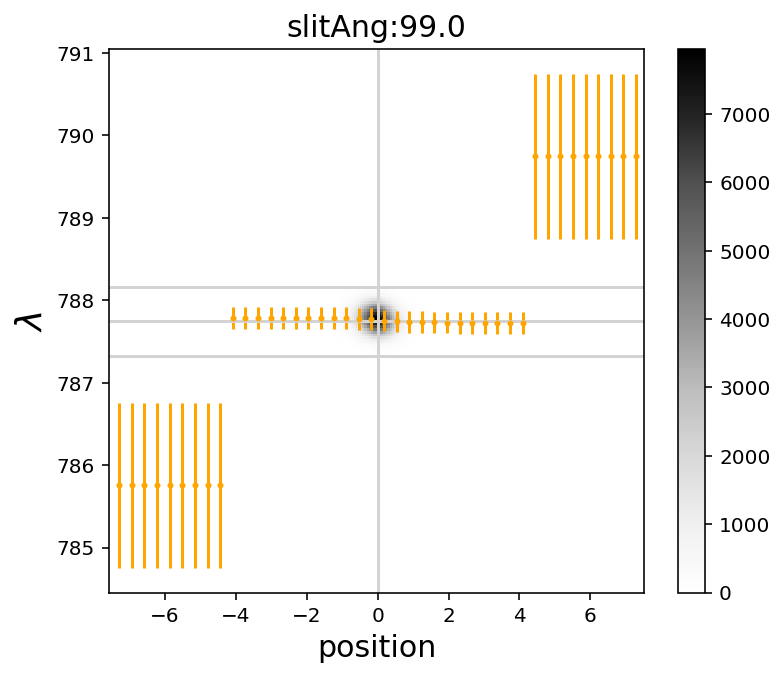

In [35]:
%matplotlib inline

j = 3

####### get pixel edges #######
lambda_min = np.min(GaussFit.grid_lambda)  ; lambda_MAX = np.max(GaussFit.grid_lambda)
x_min = np.min(GaussFit.grid_pos)          ; x_MAX = np.max(GaussFit.grid_pos)
###############################

fig,ax = plt.subplots(1,1,figsize=(6,5))

img0=ax.imshow(data_info['data_list'][j].T , extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
fig.colorbar(img0, ax=ax)

#### gaussfit image peak identification summary (yellow)
ax.errorbar(GaussFit.grid_pos[5::6], List_fitted_peak_Lambda[j][5::6], List_fitted_sigma[j][5::6] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')

#
lambda_cen = data_info['lambda_emit']*(1.+data_info['par_fid']['redshift'])
ax.axhline(lambda_cen, color='lightgray')
ax.axhline(List_fitted_peak_Lambda[0][5::6][10], color='lightgray')
ax.axhline(List_fitted_peak_Lambda[0][5::6][-15], color='lightgray')
ax.axvline(0., color='lightgray')


ax.set_xticks([-6, -4, -2, 0, 2, 4, 6])
ax.set_title('slitAng:%.1f'%slitAngDeg[j], fontsize=15)
ax.set_ylabel(r'$\lambda$', fontsize=18) 
ax.set_xlabel('position', fontsize=15)

Text(0, 0.5, 'arcmin')

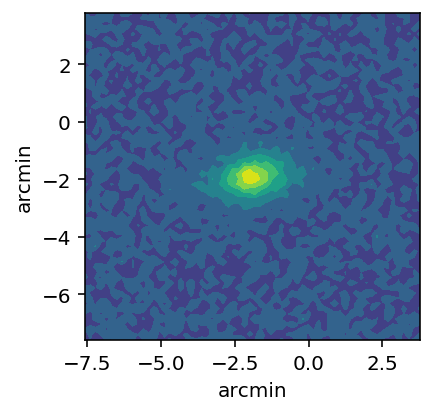

In [15]:
# check image
fig, ax = plt.subplots(1,1, figsize=(3.,3.))
ax.contourf(data_info['image'][32:96,32:96] ,extent=[x_min, x_MAX/2., x_min, x_MAX/2.])

ax.set_xlabel('arcmin')
ax.set_ylabel('arcmin')